##Importing required libraries and data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Mumbai_house_rent_99acers/Mumbai_99acers_cleaned.csv')
logdf = pd.read_csv('/content/drive/MyDrive/Datasets/Mumbai_house_rent_99acers/Mumbai_99acers_logtransformed.csv')

In [7]:
logdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12797 entries, 0 to 12796
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   society        12797 non-null  object 
 1   type           12797 non-null  object 
 2   location       12797 non-null  object 
 3   bedrooms       12797 non-null  int64  
 4   built-up area  12797 non-null  float64
 5   furnishing     12797 non-null  object 
 6   age            12797 non-null  object 
 7   floor          12797 non-null  int64  
 8   total floors   12797 non-null  int64  
 9   monthly rent   12797 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 999.9+ KB


## OneHotEncoding Text features

In [9]:
temp = pd.get_dummies(df, drop_first=True)
corr = temp.corr()['monthly rent'].sort_values()

In [47]:
logtemp = pd.get_dummies(logdf, drop_first=True)
logcorr = logtemp.corr()['monthly rent'].sort_values()

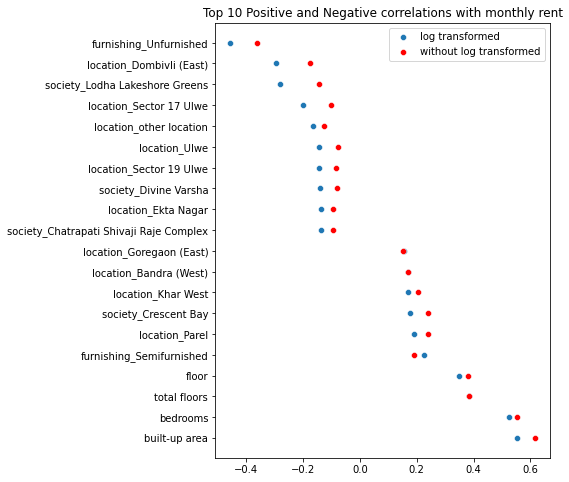

In [54]:
plt.figure(figsize=(6,8))

sns.scatterplot(y= logcorr.head(10).index.append(logcorr.tail(11)[:-1].index), 
                x= list(logcorr.head(10).values) + list(logcorr.tail(11)[:-1].values), label='log transformed')
sns.scatterplot(y= logcorr.head(10).index.append(logcorr.tail(11)[:-1].index), 
                x= corr[logcorr.head(10).index.append(logcorr.tail(11)[:-1].index)].values, color='red', label='without log transformed')
plt.title('Top 10 Positive and Negative correlations with monthly rent')
plt.legend()
plt.show()

## Preparing Training and Testing Datasets

In [103]:
x = temp.drop('monthly rent', axis = 1)
y = temp['monthly rent']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10237, 355), (2560, 355), (10237,), (2560,))

In [104]:
logx = logtemp.drop('monthly rent', axis = 1)
logy = logtemp['monthly rent']

logx_train, logx_test, logy_train, logy_test = train_test_split(logx, logy, test_size=0.2, random_state=42)
logx_train.shape, logx_test.shape, logy_train.shape, logy_test.shape

((10237, 355), (2560, 355), (10237,), (2560,))

## Scaling Datasets to convert them into same range.

In [76]:
linear = Pipeline([('scaler', StandardScaler()),
                   ('model', LinearRegression())])

In [77]:
linear.fit(X_train, y_train)
print('r2 score:',r2_score(y_test, linear.predict(X_test)))
print('rmse:',mean_squared_error(y_test, linear.predict(X_test))**.5)

r2 score: 0.8850250933959646
rmse: 12192.729520008921


In [78]:
linear.fit(logx_train,logy_train)
print('r2 score:',r2_score(logy_test, linear.predict(logx_test)))
print('rmse:',mean_squared_error(logy_test, linear.predict(logx_test))**.5)

r2 score: 0.9272080312362257
rmse: 0.19901614105818363


**Clearly log transformed help to improve score**

## Linear models

In [105]:
Final_Scores = pd.DataFrame( index = ['With Training Data r2 score','With Test Data r2 score',
                                       'With Training Data rmse', 'With Test Data rmse'])

models = [LinearRegression(), Ridge(), Lasso()]
names = ['LinearRegression', 'Ridge', 'Lasso']

for name,model in zip(names,models):

  pipeline = Pipeline([('scaler', StandardScaler()),
                    (name, model)])
  
  pipeline.fit(logx_train,logy_train)

  Final_Scores[name] = [round(r2_score(logy_train, pipeline.predict(logx_train)), 4), 
                         round(r2_score(logy_test, pipeline.predict(logx_test)), 4),
                         round(mean_squared_error(logy_train, pipeline.predict(logx_train))**.5, 4),
                         round(mean_squared_error(logy_test, pipeline.predict(logx_test))**.5, 4)]
else:
  display(Final_Scores)

,LinearRegression,Ridge,Lasso
With Training Data r2 score,0.9206,0.9206,0.0000
With Test Data r2 score,0.9272,0.9272,-0.0001
With Training Data rmse,0.2075,0.2075,0.7365
With Test Data rmse,0.1990,0.1990,0.7377


In [115]:
param_grid = {'alpha':[.001, .01, .1, 1, 10, 100]}

model = GridSearchCV(Ridge(), param_grid, cv=5)
model.fit(logx_train,logy_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [116]:
model.best_params_, model.best_score_

({'alpha': 0.01}, 0.9167601485607706)

## LabelEncoder

In [84]:
df1 = logdf.copy()
df1.head(3)

,society,type,location,bedrooms,built-up area,furnishing,age,floor,total floors,monthly rent
0,other society,Residential Apartment,Bandra (West),2,800.0,Furnished,5 to 10 years old,2,6,11.350407
1,other society,Residential Apartment,Khar West,2,1050.0,Furnished,1 to 5 years old,8,12,11.608236
2,Gajra Bhoomi Symphony,Residential Apartment,Sector-20 Koparkhairane,2,1050.0,Unfurnished,1 to 5 years old,14,17,10.373491


In [97]:
society_encoder = LabelEncoder().fit(df1['society'])
df1['society'] = society_encoder.transform(df1['society'])

type_encoder = LabelEncoder().fit(df1['type'])
df1['type'] = type_encoder.transform(df1['type'])

furnishing_encoder = LabelEncoder().fit(df1['furnishing'])
df1['furnishing'] = furnishing_encoder.transform(df1['furnishing'])

location_encoder = LabelEncoder().fit(df1['location'])
df1['location'] = location_encoder.transform(df1['location'])

age_encoder = LabelEncoder().fit(df1['age'])
df1['age'] = age_encoder.transform(df1['age'])

In [99]:
df1

,society,type,location,bedrooms,built-up area,furnishing,age,floor,total floors,monthly rent
0,176,1,8,2,800.0,0,3,2,6,11.350407
1,176,1,63,2,1050.0,0,1,8,12,11.608236
2,36,1,128,2,1050.0,3,1,14,17,10.373491
3,20,1,88,3,2275.0,2,1,40,41,11.918391
4,8,1,150,1,550.0,2,3,4,7,10.203592
...,...,...,...,...,...,...,...,...,...,...
12792,176,1,94,3,2529.0,0,1,12,32,12.072541
12793,150,1,83,3,1382.0,2,0,27,40,10.778956
12794,176,1,165,3,1750.0,3,2,9,16,12.206073
12795,176,1,109,2,950.0,2,3,8,10,10.146434


## Tree based models

In [120]:
x_train, x_test, y_train, y_test = train_test_split(df1.drop('monthly rent', axis = 1), df1['monthly rent'], test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((10237, 9), (2560, 9), (10237,), (2560,))

In [107]:
models = [DecisionTreeRegressor(), RandomForestRegressor(), XGBRegressor()]
names = ['DecisionTreeRegressor', 'RandomForestRegressor', 'XGBRegressor']

for name,model in zip(names,models):

  model.fit(x_train,y_train)

  Final_Scores[name] = [round(r2_score(y_train, model.predict(x_train)), 4), 
                         round(r2_score(y_test, model.predict(x_test)), 4),
                         round(mean_squared_error(y_train, model.predict(x_train))**.5, 4),
                         round(mean_squared_error(y_test, model.predict(x_test))**.5, 4)]
else:
  display(Final_Scores)

[21:11:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,LinearRegression,Ridge,Lasso,DecisionTreeRegressor,RandomForestRegressor,XGBRegressor
With Training Data r2 score,0.9206,0.9206,0.0000,0.9988,0.9783,0.8043
With Test Data r2 score,0.9272,0.9272,-0.0001,0.7552,0.8559,0.7945
With Training Data rmse,0.2075,0.2075,0.7365,0.0251,0.1084,0.3258
With Test Data rmse,0.1990,0.1990,0.7377,0.3650,0.2800,0.3344


##Decisiontree gridsearch

In [125]:
param_grid = {'max_depth':[3,4,5,6,7,10,15,20],
              'min_samples_leaf':[2,3,4,5,6]}

model = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5)
model.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 10, 15, 20],
                         'min_samples_leaf': [2, 3, 4, 5, 6]},
             pre_dispatch

In [126]:
model.best_params_, model.best_score_

({'max_depth': 20, 'min_samples_leaf': 6}, 0.7593420245585689)

In [127]:
round(mean_squared_error(y_train, model.predict(x_train))**.5, 4)

0.2434

In [128]:
round(mean_squared_error(y_test, model.predict(x_test))**.5, 4)

0.3439

##RandomForest gridsearch

In [132]:
param_grid = {'n_estimators':[50,100,150,200],
              'max_depth':[3,4,5,6,7,10,15,20],
              'min_samples_leaf':[2,3,4,5,6]}

model = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=5)
model.fit(x_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [133]:
model.best_params_, model.best_score_

({'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 150},
 0.837557011466955)

In [134]:
round(mean_squared_error(y_train, model.predict(x_train))**.5, 4)

0.1511

In [135]:
round(mean_squared_error(y_test, model.predict(x_test))**.5, 4)

0.2831

Still note able to beat Linear Regression

# Winner is **Linear Regression** :)